## Objective of the notebook

  Python offers plenty of libraries to create interactive charts and animation. But as a beginner, the first tool that I would learn for visualization is matplotlib. In this notebook, lets create 2 charts.

            1. World map of Active coronavirus cases as a timelapse GIF.
            2. Bar race chart for the number of deaths per country as animation.

Both using only matplotlib for charting

Please upvote if you find this notebook useful. Comments are always welcome.

## 1. World map of Active coronavirus cases as a timelapse GIF

Below output is what I am trying to achieve in this first part.

Credits for this notebook: https://youtu.be/vLEA8dCfusQ

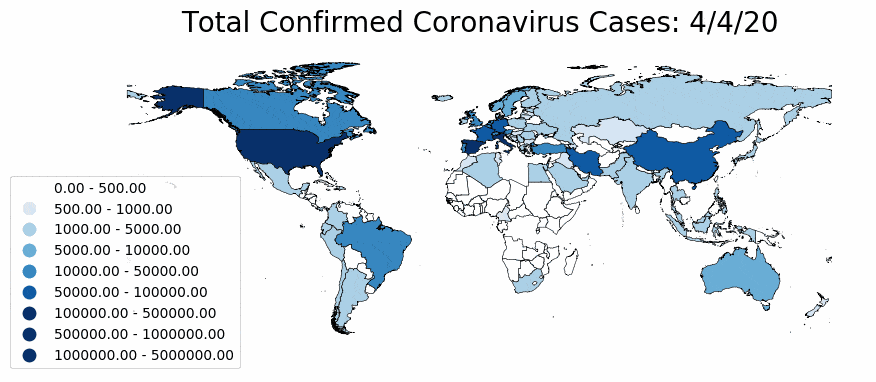

For this, first we need a shapefile. A shapefile (shp) is basically a map with coordinates. The best way to work with shp file in python is geopandas. The syntax of geopandas is somewhat similar to pandas library and we are not going to use it too much (except for reading the shp file).

Below is the link for the shp file for world map that I will be using in the notebook.

https://drive.google.com/drive/folders/1cnQHqHBuLHnEcqYq8mWc95WJNK54LPL7


Installing geopandas is the only complicated thing in this notebook. The straightforward way is to use Anaconda distribution and use the commmand  'conda install -c conda-forge geopandas'.  If it is not working, then this stackoverflow post will help you. 

https://stackoverflow.com/questions/34427788/how-to-successfully-install-pyproj-and-geopandas.

Ok let's get started


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
from datetime import datetime
import PIL
import io

import warnings
warnings.filterwarnings('ignore')

world=gpd.read_file('../input/shpfile/World_Map.shp')
confirmed=pd.read_csv('../input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv')
recovered=pd.read_csv('../input/novel-corona-virus-2019-dataset/time_series_covid_19_recovered.csv')
death=pd.read_csv('../input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths.csv')

We have three datasets each containing the total number of confirmed, recovered, and deaths per day per country. To calculate the number of active cases per day, I have subtracted the recovered and deaths from the confirmed cases.

The latitude and longitude provided in this dataset is not useful to us, since we are going to get those from the shp file that we have imported.

Since this is a broader dataset (number of columns is more), it will be difficult (atleast for me) to perform operations on them, so I stacked them, so I get a narrow dataset.

In [ ]:
confirmed=confirmed.groupby('Country/Region').sum()
confirmed.drop(['Lat','Long'], axis=1, inplace=True)
confirmed_stack=(confirmed.stack()).reset_index().rename(columns={"level_1": 'Date','Country/Region':'Country',0:'Confirmed'})

recovered=recovered.groupby('Country/Region').sum()
recovered.drop(['Lat','Long'], axis=1, inplace=True)
recovered_stack=(recovered.stack()).reset_index().rename(columns={"level_1": 'Date','Country/Region':'Country',0:'Recovered'})

death=death.groupby('Country/Region').sum()
death.drop(['Lat','Long'], axis=1, inplace=True)
death_stack=(death.stack()).reset_index().rename(columns={"level_1": 'Date','Country/Region':'Country',0:'Death'})

active=confirmed_stack.merge(recovered_stack, on=['Date','Country'], how='left')
active=active.merge(death_stack, on=['Date','Country'], how='left')
active['Active Cases']=active['Confirmed']-active['Recovered']-active['Death']

active_cases=active[['Date','Country','Active Cases']]
active_cases=active_cases.pivot_table(index='Country', columns='Date')
active_cases.columns=active_cases.columns.droplevel(0)
active_cases=active_cases.rename_axis(None, axis=1).reset_index().set_index('Country')
active_cases.head()

Now we got 2 dataframes to work with.
1. World: Contains the coordinates of a country.
2. active_cases: Containes the number of active cases per country per day.

There are some differences between how the countries are represented in both the countries. For example, "US" in one dataframse and "United States of America" in the other. So to make everything uniform, we will check for discrepancies and then join the datasets. 

In [ ]:
for index, row in active_cases.iterrows():
    if index not in world['NAME'].to_list():
        print(index + ': is not in list')
    else:
        pass

In [ ]:
world.replace('United States','US', inplace=True)
world.replace('South Korea','Korea, South', inplace=True)
world.replace('Iran (Islamic Republic of)','Iran', inplace=True)
world.replace('Taiwan','Taiwan*', inplace=True)
world.replace('Viet Nam','Vietnam*', inplace=True)

merge=world.join(active_cases, on='NAME', how='left')
merge.head()

In [ ]:
plt.rcParams.update({'figure.max_open_warning': 0}) #supresses the number of images opened warning during runtime

dates_list=merge.columns.to_list()[2:]
dates_list.sort(key=lambda date: datetime.strptime(date, "%m/%d/%y")) #to sort the dates in the list

a. Taking only the last 30 days to reduce execution time. You can remove that to make the gif from the starting date

b. classification_kwds (list of buckets) will require mapclassify. Kindly use !pip install mapclassify

c. img_frames[0] will save the first image and we are appending starting from 1 to the last image generated using our function.

d. The duration is in milliseconds (number of milliseconds an image will appear in a gif).

e. The loop=0 makes it an infinite loop. If you want, you can set it to something like loop=3, so that it will loop only 3 times and stops.

In [ ]:
img_frames=[]

for dates in dates_list[-30:]:
    ax=merge.plot(column=dates, cmap='Blues', figsize=(10,10), legend=True, edgecolor='black', linewidth=0.4, scheme='user_defined',
                 classification_kwds={'bins':[500,1000,5000,10000,50000,100000,500000,1000000]})

    ax.set_title('Active Coronavirus Cases: '+ dates, fontdict={'fontsize':20}, pad=12.5)
    ax.set_axis_off()
    ax.get_legend().set_bbox_to_anchor((0.20,0.6)) #To move the legend to a desired location. You can play with it as you wish
    img=ax.get_figure()
    
    f=io.BytesIO()  #Pillow is useful for saving the images generated in each loop and then appending it to make it a gif
    img.savefig(f, format='png', bbox_inches='tight')
    f.seek(0)
    img_frames.append(PIL.Image.open(f))
    
img_frames[0].save('Active COVID-19 Map.gif', format='GIF', append_images=img_frames[1:], save_all=True, duration=200, loop=0)

f.close()

Please note I have not executed the previous cell, but this is how your generated GIF will look like.

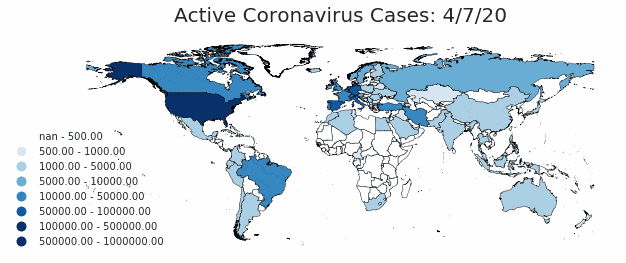

## 2. Bar race chart for the number of deaths per country.

Matplotlib provides this animation tool which will iterate over the given values on a function and displays it as an animation.

You can create this only with a few lines of code. I find it very helpful since I am familiar with matplotlib and do not need to learn other libraries for creating this visualization.

In [ ]:
df_raw=pd.read_csv('../input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths.csv')

df=df_raw.copy()

df=((df.groupby('Country/Region').sum())\
    .drop(['Lat','Long'], axis=1))\
    .stack()\
    .reset_index()\
    .rename(columns={'Country/Region':'Country','level_1': 'Date', 0:'Total'})

I do not want a single color to represent all the bars in a matplotlib bar chart which will make it difficult to track a particular country. These are just my choice of colors.

I have chosen 10 colors, and I have more than 100 countries in the list.

So I have sorted the countries in the order of highest to lowest total deaths and assigned this colors by repeating the color series, hoping that my chart do not have the same color dominating the chart which will destroy the purpose of doing this.

In [ ]:
color=['#264653', '#2a9d8f', '#e9c46a', '#f4a261','#e76f51','#f4acb7','#9f6976','#52796f','#f8ffe5','#ef476f']
 
df_dump=(df_raw.copy())\
    .drop(['Lat','Long'], axis=1)

df_dump['Total']=df_dump.sum(axis=1)

dff=(df_dump[['Country/Region','Total']])\
    .sort_values('Total',ascending=False)

repeat=int(len(dff)/len(color)+1)

dff = (dff.join(pd.DataFrame(color * repeat, columns=['Color'])))[['Country/Region','Color']]

color_dict=dict(zip(dff['Country/Region'],dff['Color']))

In [ ]:
dates=(df['Date'].drop_duplicates()).to_list()

plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "Verdana"
fig, ax=plt.subplots(figsize=(10,8))

def animate(date):
        data=(df.loc[df.Date==date,['Country','Total']]).nlargest(10,['Total'])[::-1] #selecting the top 10 countries and sorting it high to low
        ax.clear()
        ax.barh(data['Country'], data['Total'], color=[color_dict[x] for x in data['Country']])
        for i, v in enumerate(data['Total']):
            ax.text(v, i, f'{v:,.0f}')

        ax.text(0.95, 0.5, date, transform=ax.transAxes, color='#777777', size=20, ha='right', weight=1000)
        ax.set_title('Number of Deaths due to COVID-19', fontsize=20)
        ax.set_facecolor('w')
        plt.show()

#Lets pass a single date to see how it looks.
        
animate(dates[100])

The animation.FuncAnimation takes a figure parameter and a function parameter which is callable.

The 'frames' parameter will then pass the range of values specified (in our case, I have taken from the 40th date till the end in our date list) and generates the plot.

The interval parameter displays a particular plot for the mentioned milliseconds.

Please press the play button to see how the animation works.

In [ ]:
animator = animation.FuncAnimation(fig, animate, frames=dates[40:], interval=500)
HTML(animator.to_jshtml()) 